In [1]:
## import numpy as np # linear algebra
from matplotlib import pyplot as plt
#We need these in this file:
import sys
sys.path.append('cropping')
import load_read_name_extractor as lrne
import SVM_classifier_general as svm_general

#Taget fra længere nede i koden:
import torch
from torchvision import transforms
from PIL import Image
import random
import itertools
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import DeepFunctions as df
from random import shuffle
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from IPython.display import display
import os
import json
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
img_list, names = lrne.load_name_and_img("cropped_mean/*jpeg")

In [3]:
print(len(img_list))
print(len(names))

4915
4915


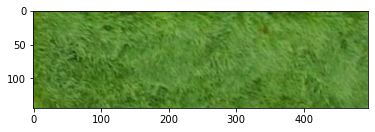

cropped_mean/206_210611_Min.jpeg


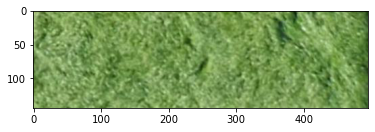

cropped_mean/124_200528_Min.jpeg


In [4]:
# pick a random index
random_index = random.randint(0, len(img_list)-1)

# get the corresponding image and name
random_img = img_list[random_index]
random_name = names[random_index]

# show the image and print the name
plt.imshow(random_img)
plt.show()
print(random_name)

# show the first image and print the name
plt.imshow(img_list[0])
plt.show()
print(names[0])


In [5]:
date_ = False
bin_size = 10
n_bins = int(np.floor(100/bin_size))
labels = svm_general.load_labels(bin_size, date_)
print(labels[0])
print(len(labels))

#convert names into [flight_folder, ROI]
names_labels = lrne.it_name_extract_labels_from_img_jpeg(names)
print(names_labels[0])
lodging_score = [[] for _ in range(4915)]

#match labels with feature names
lodging_score = svm_general.match_pic_label_to_names_new(lodging_score, labels, names_labels, date_)

['273' '35' '200612_Min' '3']
4936
['124', '200528_Min']


In [6]:
lodging_score_int = [[int(char) for char in sublist] for sublist in lodging_score]
flattened_list = list(itertools.chain.from_iterable(lodging_score_int))
#print(flattened_list)
lodging_score = flattened_list
#print(max(lodging_score_int))
count_9 = lodging_score.count(9)
print(count_9)

print(np.shape(img_list))
print(np.shape(flattened_list))

1
(4915, 144, 496, 3)
(4915,)


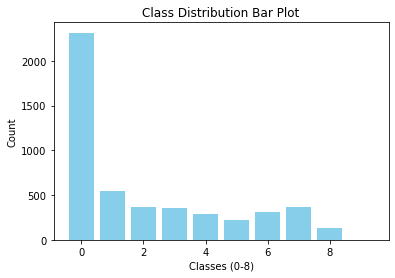

In [7]:
import matplotlib.pyplot as plt
from collections import Counter

class_counts = Counter(lodging_score)

# Create a bar plot
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')

# Add labels and title
plt.xlabel('Classes (0-8)')
plt.ylabel('Count')
plt.title('Class Distribution Bar Plot')

# Display the plot
plt.show()

# Remember to change the cuda:0 value. Should match a free GPU on the cluster or if using local probably just cuda:0.

In [8]:
# Call the function to list GPU names
df.list_gpu_names()
#R
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

Number of available GPUs: 2
GPU 0: NVIDIA GeForce RTX 3060
GPU 1: NVIDIA GeForce RTX 3060
cuda:1


In [9]:
class ImageDataset(Dataset):
    def __init__(self, img_list, lodging_score, transform=None):
        self.img_list = img_list
        self.lodging_score = lodging_score
        self.transform = transform
        self.mean = 0
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img = self.img_list[idx]
        score = self.lodging_score[idx]

        # Convert image to tensor and apply transformations
        if self.transform:
            img = self.transform(img)

        return img, score
    def get_labels(self):
        return self.lodging_score

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((144, 496)),
    #transforms.Grayscale(),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485], std=[0.229]),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

In [10]:

# Combine img_list and lodging_score
combined_data = list(zip(img_list, lodging_score))

# Shuffle the combined data
shuffle(combined_data)

# Unzip the shuffled data
img_list, lodging_score = zip(*combined_data)
dataSet = ImageDataset(img_list, lodging_score, transform=transform)
print(dataSet[0][1])
count_0 = lodging_score.count(0)
print(count_0)


6
2314


In [11]:
dataSet = df.filter_data(dataSet)
print(len(dataSet[0]))
print(len(dataSet))
print(dataSet[0][0].shape)

2
3100
torch.Size([3, 144, 496])


In [12]:
# Usage example
augmented_dataSet = df.augment_data(dataSet)
dataSet = augmented_dataSet


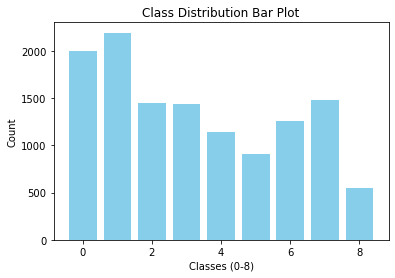

In [13]:
# Assuming dataSet is a list of tuples where the second element contains the classes
class_list = [item[1] for item in dataSet]

# Count occurrences of each class
class_counts = Counter(class_list)

# Create a bar plot
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')

# Add labels and title
plt.xlabel('Classes (0-8)')
plt.ylabel('Count')
plt.title('Class Distribution Bar Plot')

# Display the plot
plt.show()

In [14]:
print(len(dataSet[0]))
print(len(dataSet))
#print(type(dataSet[0][0]))


# Assuming img is a PIL.Image.Image object
display(dataSet[0][0].shape)

2
12400


torch.Size([3, 144, 496])

In [15]:
#Split into train and validation set
random_seed = 10587
testValSize = (2/5) * len(dataSet)
trainDataset, testvalDataset = train_test_split(dataSet, test_size=int(testValSize), random_state=random_seed, shuffle=True)
validationSize = (1/2) * len(testvalDataset)
testDataset, valDataset = train_test_split(testvalDataset, test_size=int(validationSize), random_state=random_seed, shuffle=True)

#Create dataloaders
batchSize = 64
trainDataloader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
testDataloader = DataLoader(testDataset, batch_size=batchSize, shuffle=True)
valDataloader = DataLoader(valDataset, batch_size=batchSize, shuffle=True)

#Print sizes
print(len(trainDataset), len(testDataset), len(valDataset))
print(dataSet[0][0].shape)

7440 2480 2480
torch.Size([3, 144, 496])


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#We have ignored class 9 since there were only 1 image with that class. Therfore we have 9 classes.
num_classes = 9
channels = dataSet[0][0].shape[0]
height = dataSet[0][0].shape[1]
width = dataSet[0][0].shape[2]
print(channels)
print(height)
print(width)

3
144
496


In [17]:
import torch
import torch.nn as nn

class ParallelResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ParallelResidualBlock, self).__init__()

        # First path: Identity path
        self.identity_path = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        # Second path: Convolutional path
        self.conv_path = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        # Third path: Another Convolutional path
        self.another_conv_path = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        identity_output = self.identity_path(x)
        conv_output = self.conv_path(x)
        another_conv_output = self.another_conv_path(x)

        # Combine the outputs
        output = identity_output + conv_output + another_conv_output

        return output

In [18]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3,stride=1):
        super(ResidualBlock, self).__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection (identity mapping)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Add the shortcut connection
        out += self.shortcut(residual)
        out = self.relu(out)

        return out

In [19]:
kernel_size = 3
kernel_size1 = 3
padding = 0
# define network
conv1toconv2 = 16
conv2toconv3 = 32
conv3toconv4 = 64
conv4toconv5 = 128
conv5tores1 = 256
res1tores2 = 256
res2tores3 = 256
res3tores4 = 256
res4tores5 = 256
res5tores6 = 256
res6tolin1 = 256
lin = 256

class NeuralNetwork(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(NeuralNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, conv1toconv2, kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(conv1toconv2)
        self.conv2 = nn.Conv2d(conv1toconv2, conv2toconv3, kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(conv2toconv3)
        self.conv3 = nn.Conv2d(conv2toconv3, conv3toconv4, kernel_size, padding=padding)
        self.bn3 = nn.BatchNorm2d(conv3toconv4)
        self.conv4 = nn.Conv2d(conv3toconv4, conv4toconv5, kernel_size, padding=padding)
        self.bn4 = nn.BatchNorm2d(conv4toconv5)
        self.conv5 = nn.Conv2d(conv4toconv5, conv5tores1, kernel_size, padding=padding)
        self.bn5 = nn.BatchNorm2d(conv5tores1)
        
        self.residual1 = ResidualBlock(conv5tores1, res1tores2)
        self.residual2 = ResidualBlock(res1tores2, res2tores3)
        self.residual3 = ResidualBlock(res2tores3, res3tores4)
        self.residual4 = ResidualBlock(res4tores5, res4tores5)
        self.residual5 = ResidualBlock(res4tores5, res5tores6)
        self.residual6 = ResidualBlock(res5tores6, res6tolin1)
        
        self.pool = nn.AvgPool2d(2, 2)
        self.poolmax = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.FC1 = nn.Linear(6 * res6tolin1, lin)
        self.bn7 = nn.BatchNorm1d(lin)
        self.FC2 = nn.Linear(lin,lin)
        self.bn8 = nn.BatchNorm1d(lin)
        self.FC3 = nn.Linear(lin, num_classes)
        self.bn9 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        #print(x.shape)
        x = self.poolmax(x)
        
        #print(x.shape)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        #print(x.shape)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)
        
                                  
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool(x)
        #print(x.shape)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.pool(x)
        #print(x.shape)
        
        self.residual1(x)
        self.residual2(x)
        self.residual3(x)
        self.residual4(x)
        self.residual5(x)
        self.residual6(x)
        
        x = self.pool(x)
        
        x = self.flatten(x)
        x = self.FC1(x)
        x = self.bn7(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.FC2(x)
        x = self.bn8(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.FC3(x)
        return x

In [20]:
class LabelSmoothBCEWithLogitsLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothBCEWithLogitsLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, input, target):
        target = target * (1 - self.smoothing) + 0.5 * self.smoothing
        loss = nn.BCEWithLogitsLoss()(input, target)
        return loss


In [ ]:
#%%capture output
done=False
learning_rates = [0.001]
patience_values = [10]
weight_decay_values =[1e-4]
best_val_acc = 0.0
best_hyperparameters = {}

# Set the number of epochs
num_epochs = 80
totalAcc = 0

trainAccList = []
valAccList = []
trainLossList = []
valLossList = []

# Variables for early stopping
best_val_accuracy = 0.0
patience = 100  # Number of epochs to wait for improvement
counter = 0  # Counter for consecutive epochs without improvement


# Training loop + tuning
for learning_rate in learning_rates:
    for weight_decay in weight_decay_values:
        for patience in patience_values:
            net = NeuralNetwork()
            print("start")
            net.to(device)
            #print(net)
            #learning_rate = 0.001
            # Define the optimizer
            criterion = LabelSmoothBCEWithLogitsLoss(smoothing=0.2).to(device)
            optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
            scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience, verbose=True)

            trainAccList = []
            valAccList = []
            trainLossList = []
            valLossList = []
            # Training loop
            for epoch in range(num_epochs):
                running_loss = 0.0
                totalAcc = 0.0
                val_running_loss = 0.0
                val_totalAcc = 0.0

                for i, data in enumerate(trainDataloader, 0):
                    net.train()
                    # Get the inputs and labels
                    inputs, labels = data

                    inputs, labels = inputs.to(device), labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    outputs = net(inputs)
                    totalAcc += torch.eq(torch.argmax(outputs, dim=1), labels).sum()

                    labels_one_hot = F.one_hot(labels, num_classes)
        
                    loss = criterion(outputs, labels_one_hot.float())

                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()

                    # Print statistics
                    running_loss += loss.item()
                    del(inputs)
                    del(labels)
                    

                for i, data in enumerate(valDataloader, 0):
                    net.eval()
                    # Get the inputs and labels
                    inputs, labels = data
                    data=None
                    inputs, labels = inputs.to(device), labels.to(device)

                    # Forward pass
                    outputs = net(inputs)
                    val_totalAcc += torch.eq(torch.argmax(outputs, dim=1), labels).sum()

                    labels_one_hot = F.one_hot(labels, num_classes)
        
                    loss = criterion(outputs, labels_one_hot.float())

                    # Print statistics
                    val_running_loss += loss.item()
                    del(inputs)
                    del(labels)

                scheduler.step(val_running_loss)

                trainAccList.append(totalAcc/len(trainDataset))
                valAccList.append(val_totalAcc/len(valDataset))
                trainLossList.append(running_loss/len(trainDataloader))
                valLossList.append(val_running_loss/len(valDataloader))
                print('[%d] train loss: %.3f train acc: %.3f val loss: %.3f val acc: %.3f '
                      % (epoch + 1,trainLossList[epoch],  trainAccList[epoch], valLossList[epoch], valAccList[epoch]))
                running_loss = 0.0
                totalAcc = 0.0
                val_running_loss = 0.0
                val_totalAcc = 0.0
                current_learning_rate = optimizer.param_groups[0]['lr']
                # Break if totalAcc is above 0.95
                if trainAccList[epoch] > 0.95 or current_learning_rate < 1e-6:
                    print("Training accuracy reached above 0.95 or learning rate below 1e-6. Stopping training.")
                    break
            cm1, acc1 = df.create_confusion_matrix(trainDataloader, net, device=device)
            title1 = 'Confusion matrix for training set'

            cm2, acc2 = df.create_confusion_matrix(valDataloader, net, device=device)
            title2 = 'Confusion matrix for validation set'

            cm3, acc3 = df.create_confusion_matrix(testDataloader, net, device=device)
            title3 = 'Confusion matrix for test set'

            df.plot_3_confusion_matrices(cm1, cm2, cm3, acc1, acc2, acc3, num_classes, title1, title2, title3)
            print('Finished training')
            df.save_training_data_to_file(df.transfer_to_cpu([learning_rate,weight_decay,patience]),df.transfer_to_cpu(trainLossList)
                                  ,df.transfer_to_cpu(trainAccList),df.transfer_to_cpu(valLossList)
                                  ,df.transfer_to_cpu(valAccList))
print("Best Hyperparameters:", best_hyperparameters)
done=True

start
[1] train loss: 0.487 train acc: 0.297 val loss: 0.461 val acc: 0.344 
[2] train loss: 0.464 train acc: 0.341 val loss: 0.460 val acc: 0.340 
[3] train loss: 0.459 train acc: 0.358 val loss: 0.464 val acc: 0.358 
[4] train loss: 0.457 train acc: 0.368 val loss: 0.451 val acc: 0.394 
[5] train loss: 0.455 train acc: 0.387 val loss: 0.451 val acc: 0.384 
[6] train loss: 0.453 train acc: 0.390 val loss: 0.453 val acc: 0.369 
[7] train loss: 0.452 train acc: 0.397 val loss: 0.450 val acc: 0.388 
[8] train loss: 0.451 train acc: 0.401 val loss: 0.445 val acc: 0.428 
[9] train loss: 0.450 train acc: 0.402 val loss: 0.468 val acc: 0.316 
[10] train loss: 0.449 train acc: 0.416 val loss: 0.446 val acc: 0.406 
[11] train loss: 0.448 train acc: 0.422 val loss: 0.443 val acc: 0.442 
[12] train loss: 0.448 train acc: 0.417 val loss: 0.443 val acc: 0.448 
[13] train loss: 0.446 train acc: 0.438 val loss: 0.441 val acc: 0.444 
[14] train loss: 0.447 train acc: 0.425 val loss: 0.441 val acc: 0.

In [ ]:
if done:
	output.show() # displays captured output
else:
	print("cell above still seem to be running, wait some more..")

In [ ]:
device = "cuda:3"
# Check the current GPU memory usage in bytes
current_memory = torch.cuda.memory_allocated(device=device)
print(f"Current GPU memory usage: {current_memory / (1024**3):.2f} GB")

# Check the GPU memory reserved by PyTorch (memory that can be freed, but is not returned to the OS)
reserved_memory = torch.cuda.memory_reserved(device=device)
print(f"GPU memory reserved by PyTorch: {reserved_memory / (1024**3):.2f} GB")

In [ ]:
print(net)

In [ ]:
df.plot_loss_and_accuracy(df.transfer_to_cpu(trainLossList), df.transfer_to_cpu(trainAccList), df.transfer_to_cpu(valLossList), df.transfer_to_cpu(valAccList))

In [ ]:
cm1, acc1 = df.create_confusion_matrix(trainDataloader, net, device=device)
title1 = 'Confusion matrix for training set'

cm2, acc2 = df.create_confusion_matrix(valDataloader, net, device=device)
title2 = 'Confusion matrix for validation set'

cm3, acc3 = df.create_confusion_matrix(testDataloader, net, device=device)
title3 = 'Confusion matrix for test set'

df.plot_3_confusion_matrices(cm1, cm2, cm3, acc1, acc2, acc3, num_classes, title1, title2, title3)

In [ ]:


# Example usage:
# Assuming you have your confusion matrices and accuracies
layer_sizes = [conv1toconv2, conv2toconv3, conv3toconv4, conv4toconv5, conv5toconv6, conv6tolin1]

# Save the results to a file
df.save_results_to_file(layer_sizes, cm1, acc1, cm2, acc2, cm3, acc3)


## 